# Grouped By Graph Type CNN Model With Contamination Using Scanpaths - Conati Architecture With 5x5 Kernel

In [11]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

In [ ]:
# Common settings
img_height = 288
img_width = 512
batch_size = 32

# Get the project root directory
# Try to find project root by looking for "Scanpaths" folder
current_dir = os.getcwd()
project_root = current_dir

# Navigate up to find project root (where "Scanpaths" exists)
for _ in range(3):  # Check up to 3 levels up
    if os.path.exists(os.path.join(current_dir, "Scanpaths")):
        project_root = current_dir
        break
    parent = os.path.dirname(current_dir)
    if parent == current_dir:  # Reached filesystem root
        break
    current_dir = parent

# Base dataset path: Scanpaths/organized_by_graph_type_contaminated (at project root)
base_dataset_path = os.path.join(project_root, "Scanpaths", "organized_by_graph_type_contaminated")

# Print path for verification
print(f"Project root: {project_root}")
print(f"Base dataset path: {base_dataset_path}")

In [13]:

# Function to create a model (based on the paper's CNN architecture, with original input size)
def create_model():
    model = models.Sequential([
        layers.Input(shape=(288, 512, 1)),  # Original resolution, grayscale

        layers.Conv2D(16, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(6, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
# Train and evaluate one fold
def train_and_evaluate(dataset_name, fold, average_results):
    dataset_path = os.path.join(base_dataset_path, dataset_name)

    # Load datasets (RGB by default)
    train_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

    val_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

    # Convert RGB to grayscale
    def convert_to_grayscale(image, label):
        image = tf.image.rgb_to_grayscale(image)
        return image, label

    train_ds = train_ds.map(convert_to_grayscale)
    val_ds = val_ds.map(convert_to_grayscale)

    model = create_model()

    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[early_stop]
    )

    # Plot accuracy
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{dataset_name} - Training vs Validation Accuracy - Fold {fold + 1}')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{dataset_name} - Training vs Validation Loss - Fold {fold + 1}')
    plt.legend()
    plt.show()

    # Evaluate on validation set
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy().astype(int))
        y_pred.extend((preds > 0.5).astype(int).flatten())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Illiterate", "Literate"], yticklabels=["Illiterate", "Literate"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{dataset_name} - Confusion Matrix - Fold {fold + 1}')
    plt.show()

    # Track final epoch accuracy
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    average_results["train_accuracies"].append(final_train_acc)
    average_results["val_accuracies"].append(final_val_acc)

    print(f"Fold {fold + 1} Final Train Acc: {final_train_acc:.4f}, Final Val Acc: {final_val_acc:.4f}")



=== Running 5-fold CV for: bar ===
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.5297 - loss: 175.5879 - val_accuracy: 0.5677 - val_loss: 0.6910
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.5843 - loss: 0.6850 - val_accuracy: 0.5548 - val_loss: 0.6923
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.6798 - loss: 0.6754 - val_accuracy: 0.5935 - val_loss: 0.6913
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.7154 - loss: 0.6561 - val_accuracy: 0.5677 - val_loss: 0.6899
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.6986 - loss: 0.6418 - val_accuracy: 0.5677 - val_loss: 0.6901
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.7333 - loss: 0.5923 - val_accuracy: 0.5677 - val_loss: 0.6993


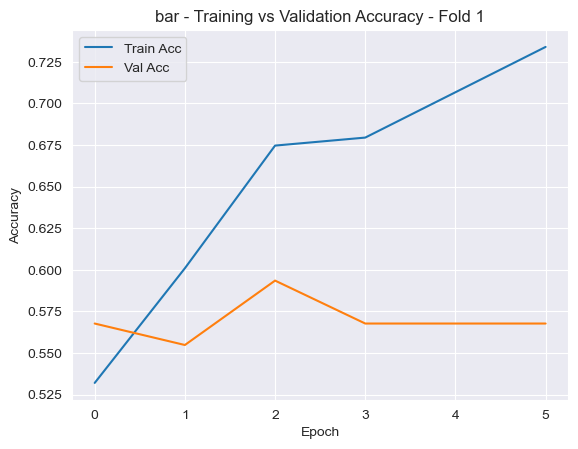

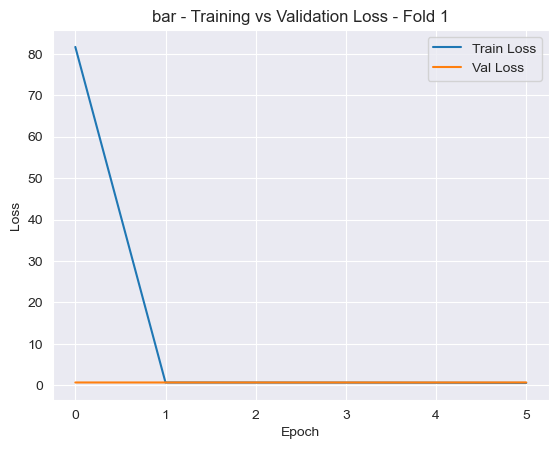

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


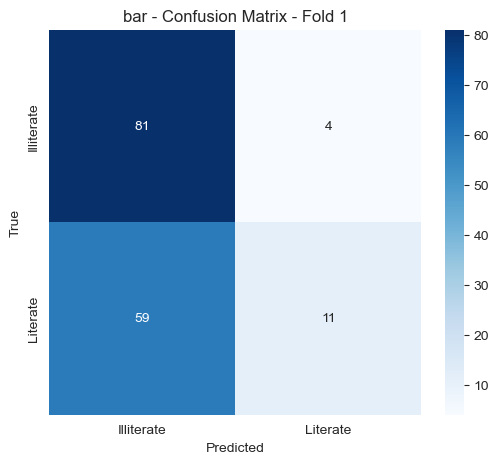

Fold 1 Final Train Acc: 0.7340, Final Val Acc: 0.5677
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.5051 - loss: 75.6138 - val_accuracy: 0.4387 - val_loss: 0.6949
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5881 - loss: 0.6687 - val_accuracy: 0.5226 - val_loss: 0.6984
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.7502 - loss: 0.5492 - val_accuracy: 0.6387 - val_loss: 0.7098
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9084 - loss: 0.2759 - val_accuracy: 0.6194 - val_loss: 0.7470
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9588 - loss: 0.1599 - val_accuracy: 0.5871 - val_loss: 0.9145
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9746 - loss: 0.0550 - val_accuracy: 0.6258 - val_loss: 1.5742


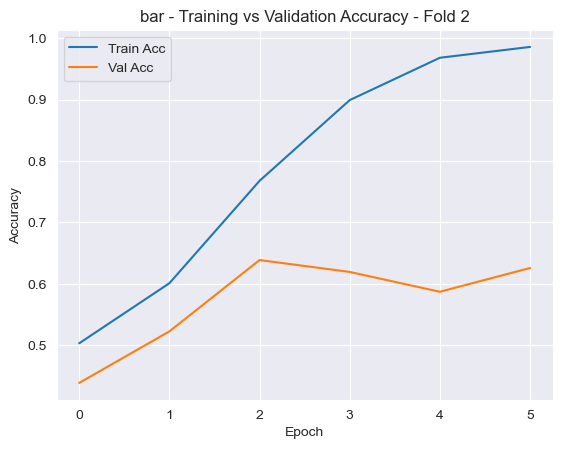

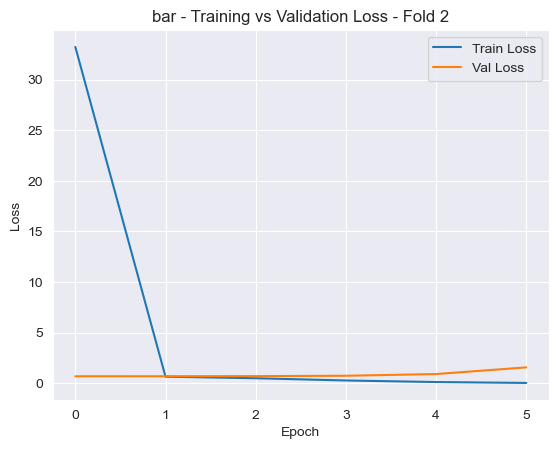

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


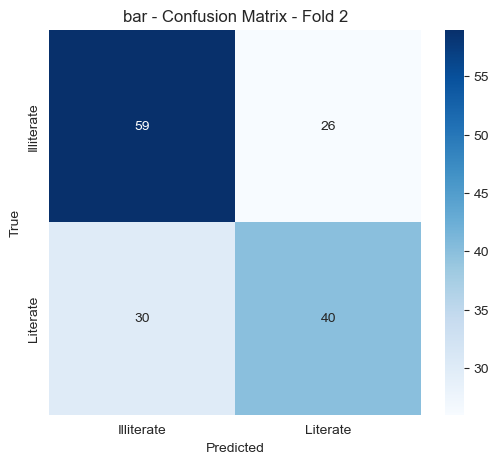

Fold 2 Final Train Acc: 0.9856, Final Val Acc: 0.6258
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.5366 - loss: 302.1712 - val_accuracy: 0.4516 - val_loss: 0.6932
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.4772 - loss: 0.6932 - val_accuracy: 0.5484 - val_loss: 0.6930
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.5754 - loss: 0.6929 - val_accuracy: 0.5484 - val_loss: 0.6927
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.6090 - loss: 0.6921 - val_accuracy: 0.5484 - val_loss: 0.6924
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5718 - loss: 0.6919 - val_accuracy: 0.5484 - val_loss: 0.6921


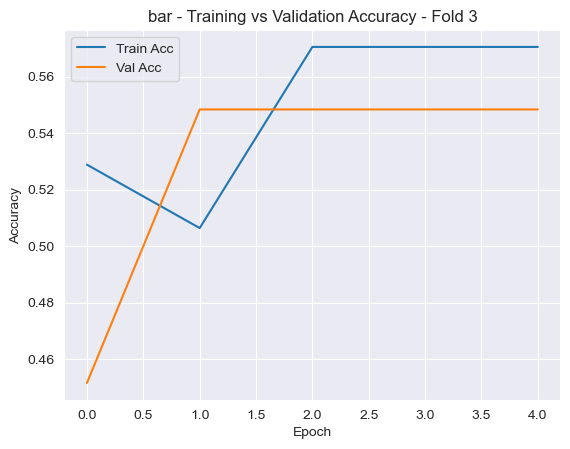

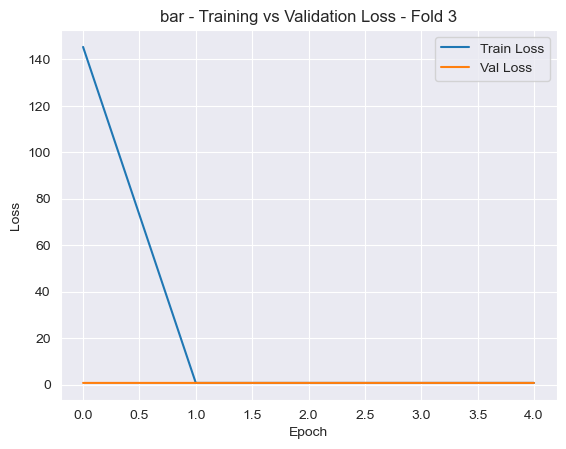

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


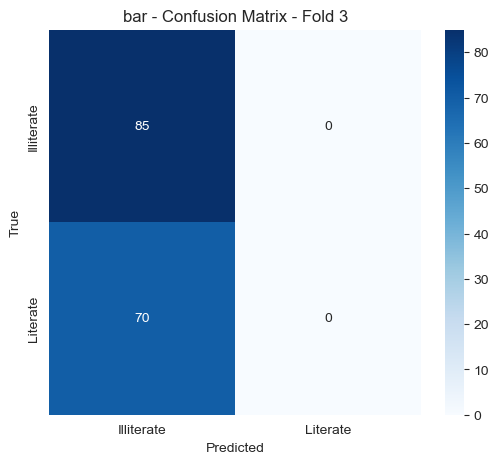

Fold 3 Final Train Acc: 0.5705, Final Val Acc: 0.5484
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.5297 - loss: 1.0444 - val_accuracy: 0.4194 - val_loss: 0.6989
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.6844 - loss: 0.6028 - val_accuracy: 0.5419 - val_loss: 0.7533
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.8601 - loss: 0.3847 - val_accuracy: 0.5419 - val_loss: 1.1139
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9543 - loss: 0.1467 - val_accuracy: 0.5677 - val_loss: 1.2625
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9792 - loss: 0.0555 - val_accuracy: 0.5871 - val_loss: 1.6273
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9915 - loss: 0.0339 - val_accuracy: 0.5419 - val_loss: 2.1771
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━

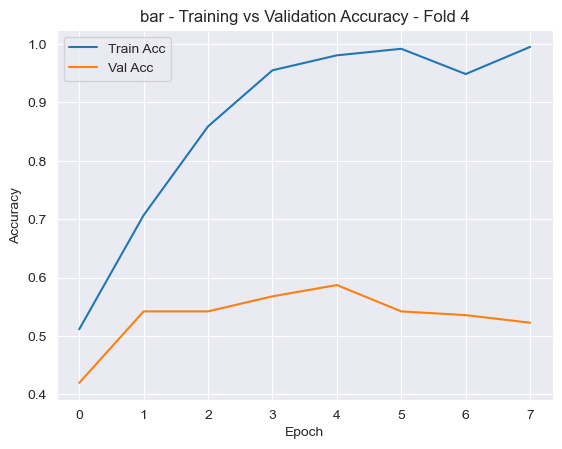

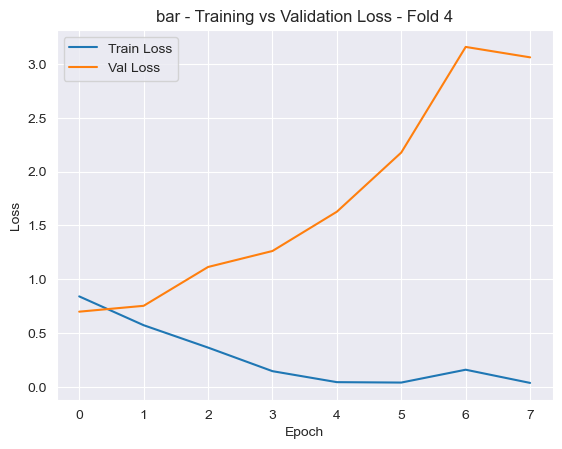

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


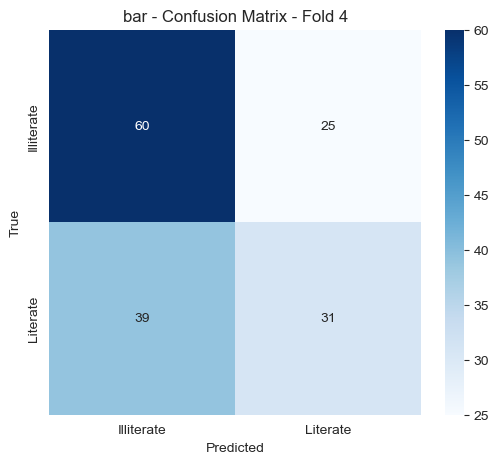

Fold 4 Final Train Acc: 0.9952, Final Val Acc: 0.5226
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.4685 - loss: 7.5483 - val_accuracy: 0.4903 - val_loss: 0.6959
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.6869 - loss: 0.6081 - val_accuracy: 0.5290 - val_loss: 0.6942
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.6854 - loss: 0.5680 - val_accuracy: 0.4968 - val_loss: 0.7734
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.8342 - loss: 0.3721 - val_accuracy: 0.5548 - val_loss: 1.0438
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9219 - loss: 0.1869 - val_accuracy: 0.6000 - val_loss: 1.4752
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9781 - loss: 0.0510 - val_accuracy: 0.5484 - val_loss: 2.6820
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━

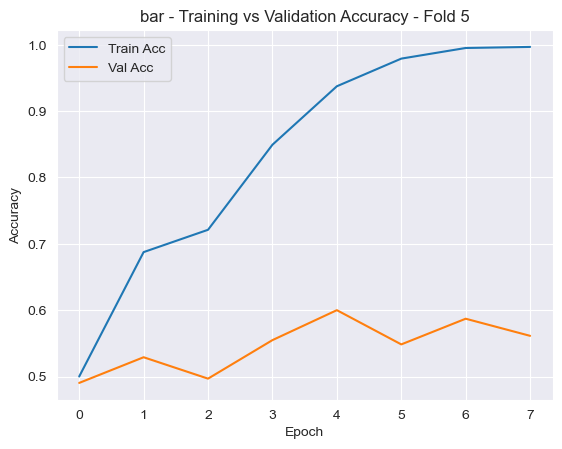

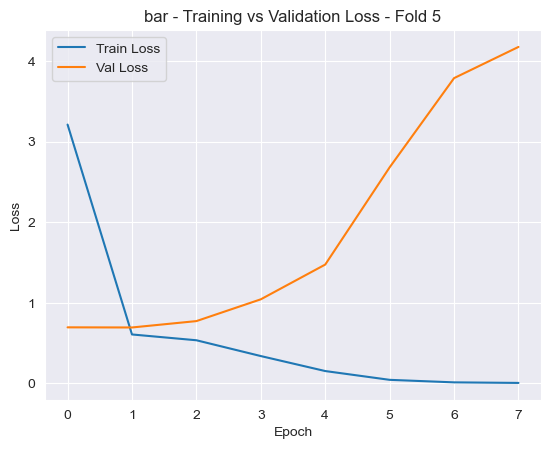

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


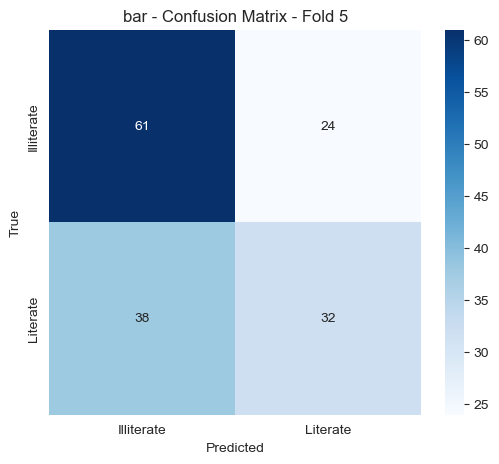

Fold 5 Final Train Acc: 0.9968, Final Val Acc: 0.5613

=== Running 5-fold CV for: line ===
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.4709 - loss: 544.5304 - val_accuracy: 0.5965 - val_loss: 0.6767
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.6154 - loss: 0.6764 - val_accuracy: 0.5702 - val_loss: 0.6870
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7003 - loss: 0.6319 - val_accuracy: 0.7632 - val_loss: 0.7824
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.8381 - loss: 0.4284 - val_accuracy: 0.6667 - val_loss: 0.5705
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9667 - loss: 0.1513 - val_accuracy: 0.7544 - val_loss: 0.7481
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9823 - loss: 0.0840 - val_accuracy: 0.7368 - val_loss: 1.70

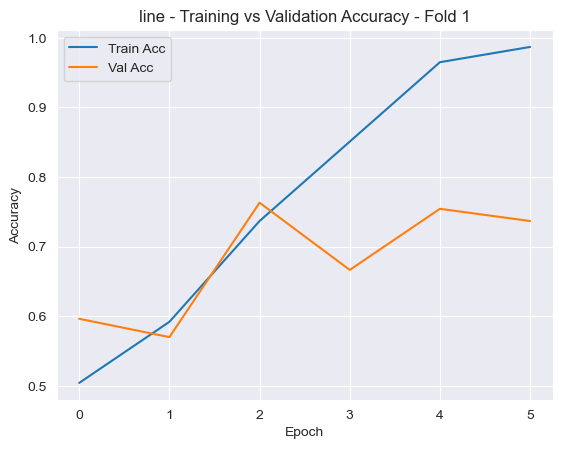

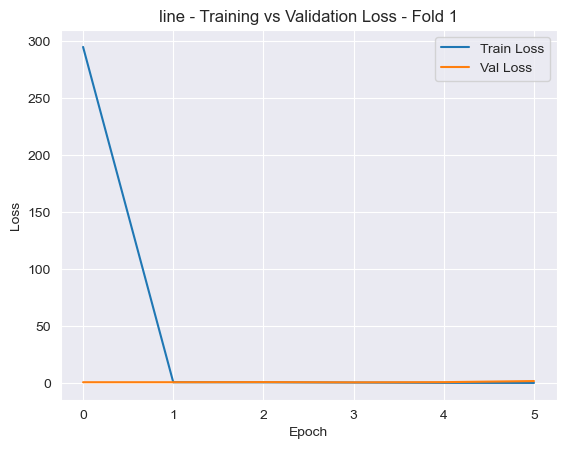

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


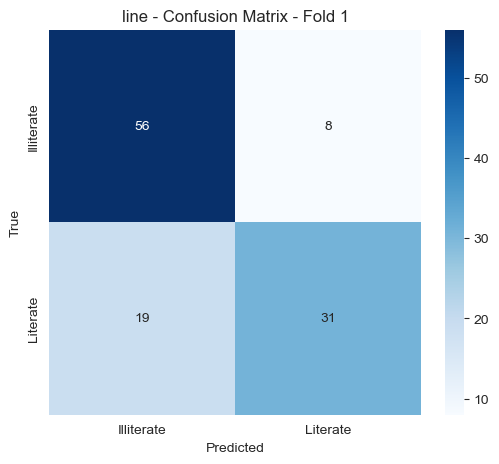

Fold 1 Final Train Acc: 0.9868, Final Val Acc: 0.7368
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5647 - loss: 467.8445 - val_accuracy: 0.4737 - val_loss: 0.6952
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.5013 - loss: 0.6854 - val_accuracy: 0.5789 - val_loss: 0.6952
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.6004 - loss: 0.6836 - val_accuracy: 0.6053 - val_loss: 0.6923
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.7404 - loss: 0.6198 - val_accuracy: 0.6930 - val_loss: 0.7233
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7985 - loss: 0.4271 - val_accuracy: 0.6228 - val_loss: 0.7112
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9361 - loss: 0.1871 - val_accuracy: 0.6316 - val_loss: 0.9478
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━

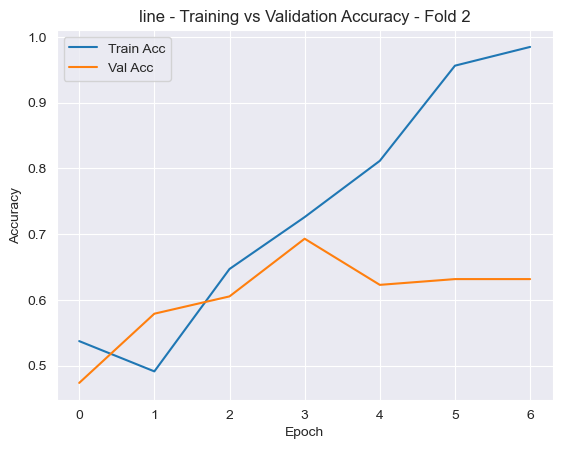

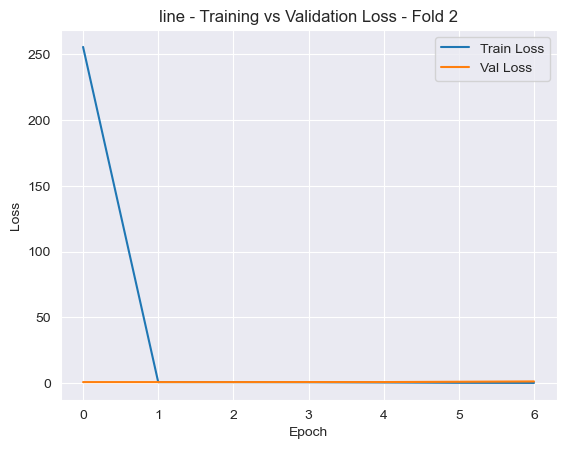

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


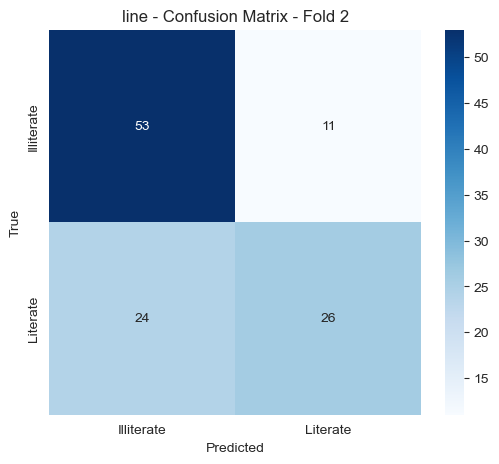

Fold 2 Final Train Acc: 0.9846, Final Val Acc: 0.6316
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.5365 - loss: 271.0042 - val_accuracy: 0.5088 - val_loss: 0.7259
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.5601 - loss: 0.7110 - val_accuracy: 0.6140 - val_loss: 0.6939
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.5617 - loss: 0.6869 - val_accuracy: 0.5263 - val_loss: 0.6948
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.5680 - loss: 0.6870 - val_accuracy: 0.5439 - val_loss: 0.6936
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.5625 - loss: 0.6851 - val_accuracy: 0.5351 - val_loss: 0.6924


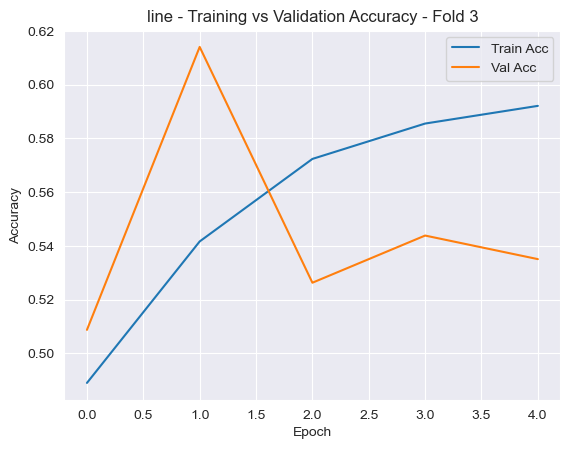

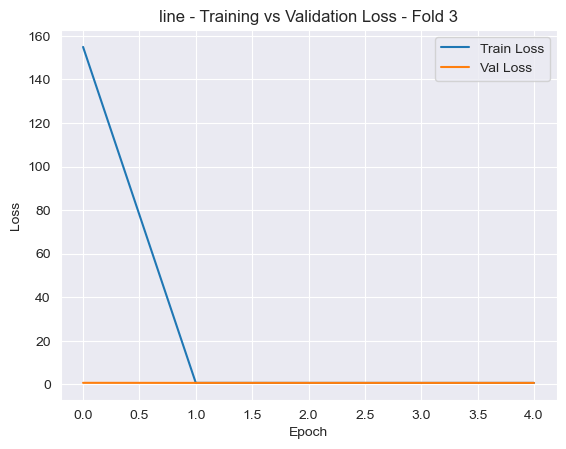

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


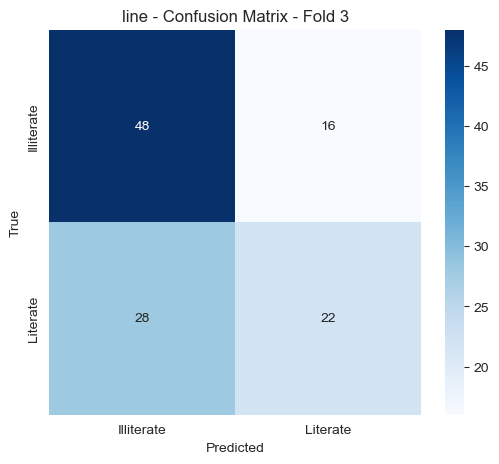

Fold 3 Final Train Acc: 0.5921, Final Val Acc: 0.5351
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.5533 - loss: 528.7108 - val_accuracy: 0.5614 - val_loss: 0.6929
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.5566 - loss: 0.6929 - val_accuracy: 0.5614 - val_loss: 0.6928
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.5483 - loss: 0.6928 - val_accuracy: 0.5614 - val_loss: 0.6926
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.5540 - loss: 0.6926 - val_accuracy: 0.5614 - val_loss: 0.6923


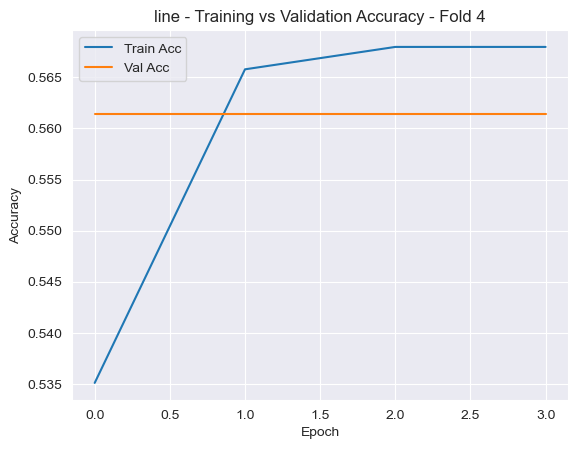

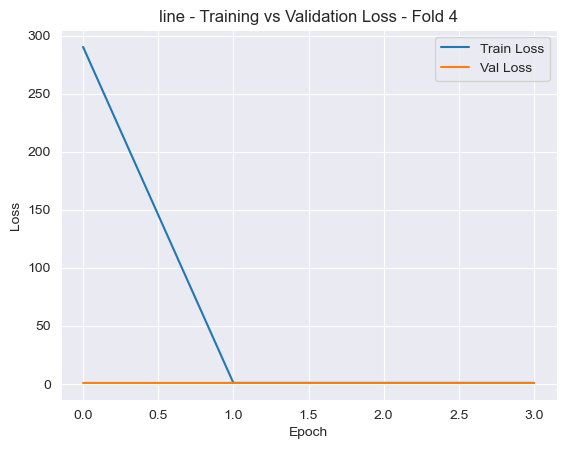

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


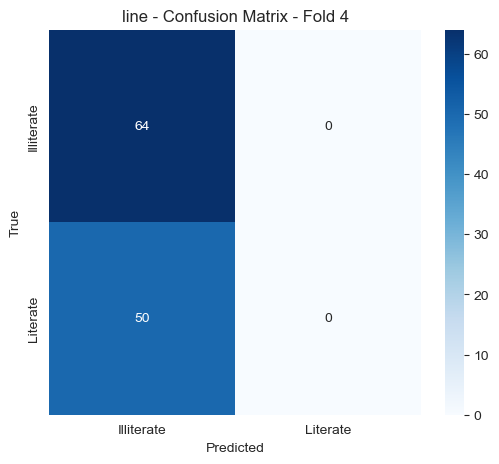

Fold 4 Final Train Acc: 0.5680, Final Val Acc: 0.5614
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.5735 - loss: 93.4713 - val_accuracy: 0.5439 - val_loss: 0.6925
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7130 - loss: 0.6492 - val_accuracy: 0.7018 - val_loss: 0.5687
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7942 - loss: 0.3867 - val_accuracy: 0.6842 - val_loss: 0.6806
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9483 - loss: 0.1497 - val_accuracy: 0.6316 - val_loss: 1.0696
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9333 - loss: 0.2007 - val_accuracy: 0.7807 - val_loss: 0.7313
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9694 - loss: 0.0769 - val_accuracy: 0.7193 - val_loss: 0.8448
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━

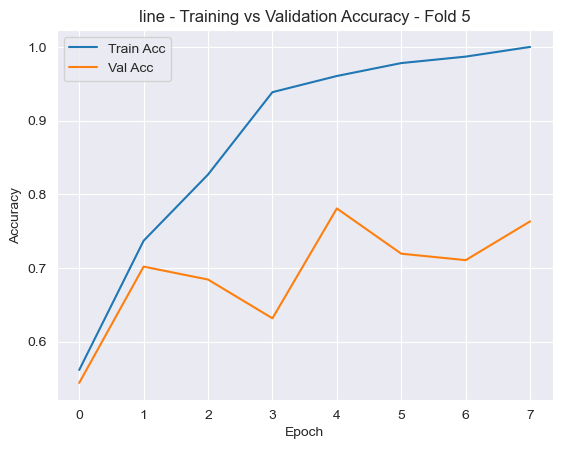

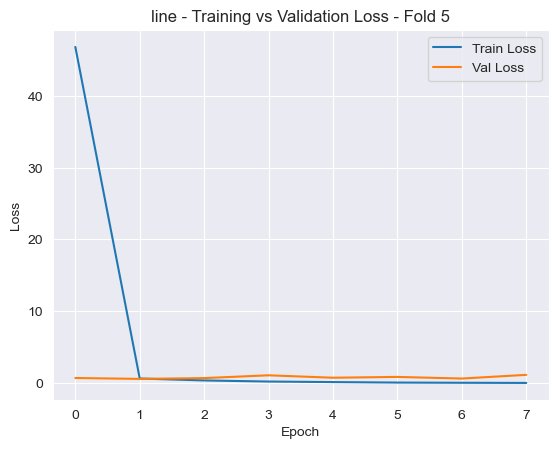

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


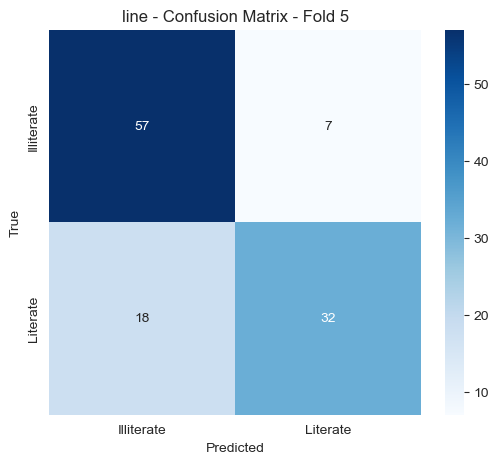

Fold 5 Final Train Acc: 1.0000, Final Val Acc: 0.7632

=== Running 5-fold CV for: pie ===
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.5410 - loss: 1592.9387 - val_accuracy: 0.4000 - val_loss: 10.3205
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.5181 - loss: 7.0449 - val_accuracy: 0.4333 - val_loss: 0.6913
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.6438 - loss: 0.7066 - val_accuracy: 0.4667 - val_loss: 0.6921
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.5969 - loss: 0.6751 - val_accuracy: 0.5333 - val_loss: 0.6936
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.6258 - loss: 0.6854 - val_accuracy: 0.4333 - val_loss: 0.6939
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.6333 - loss: 0.6895 - val_accuracy: 0.4000 - val_loss: 0.6946
Epoch 7/1

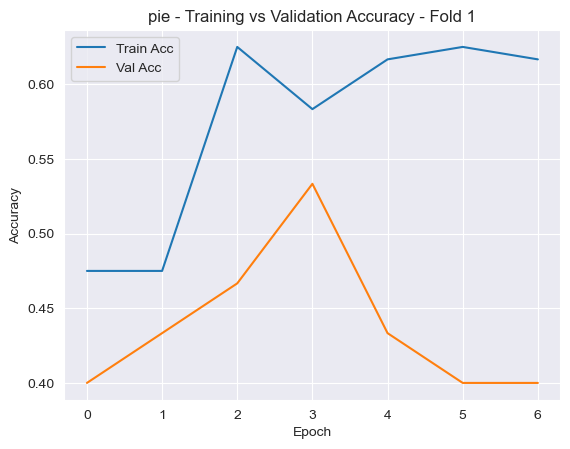

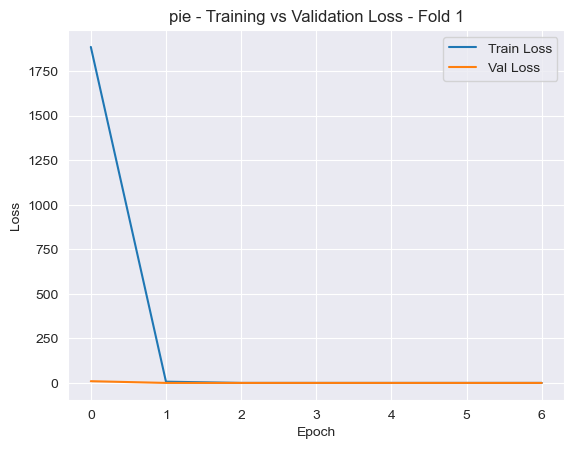

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


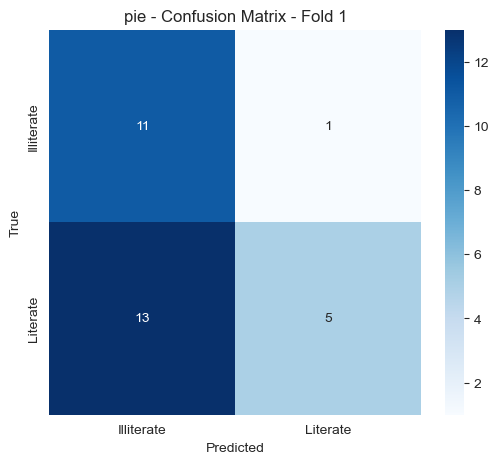

Fold 1 Final Train Acc: 0.6167, Final Val Acc: 0.4000
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.5410 - loss: 310.8207 - val_accuracy: 0.4000 - val_loss: 60.0926
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.5760 - loss: 24.4517 - val_accuracy: 0.6000 - val_loss: 0.6562
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.7529 - loss: 0.5566 - val_accuracy: 0.5000 - val_loss: 0.8520
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.8854 - loss: 0.2661 - val_accuracy: 0.6000 - val_loss: 1.5019
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9594 - loss: 0.0988 - val_accuracy: 0.6667 - val_loss: 0.7246
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 0.0555 - val_accuracy: 0.6333 - val_loss: 0.7198
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/

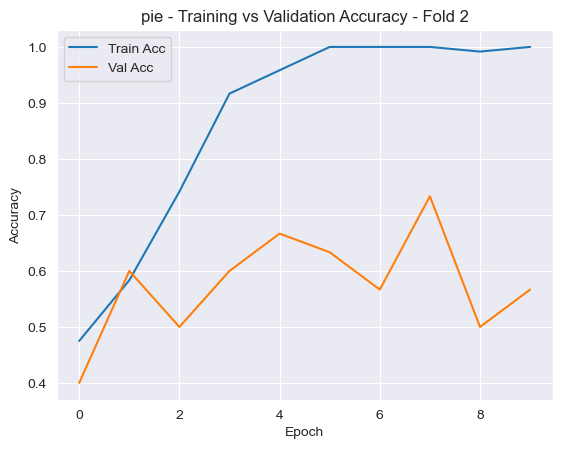

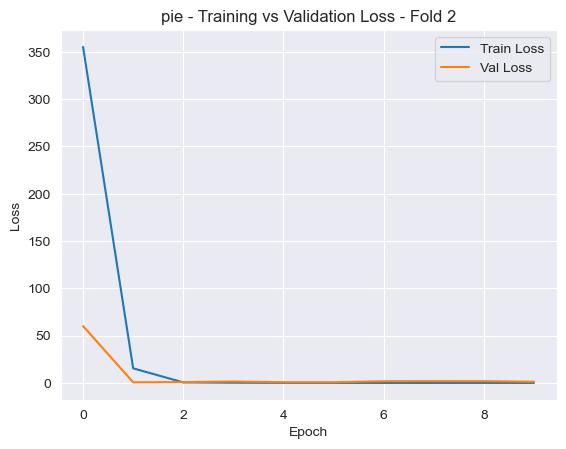

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


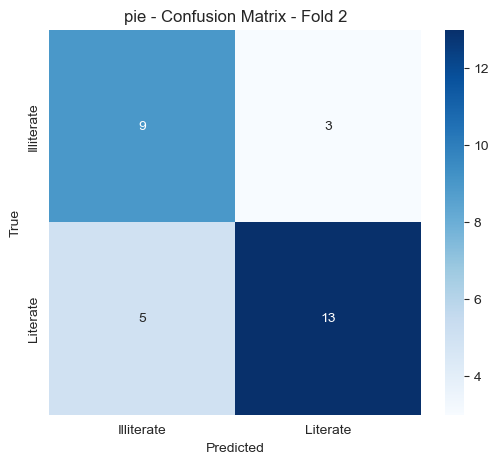

Fold 2 Final Train Acc: 1.0000, Final Val Acc: 0.5667
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.5410 - loss: 724.6844 - val_accuracy: 0.4000 - val_loss: 369.1898
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.5923 - loss: 198.2995 - val_accuracy: 0.4000 - val_loss: 2.0495
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.6542 - loss: 0.8579 - val_accuracy: 0.4333 - val_loss: 0.8629
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9042 - loss: 0.2977 - val_accuracy: 0.4333 - val_loss: 1.0108
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9800 - loss: 0.2266 - val_accuracy: 0.6667 - val_loss: 0.8482
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9517 - loss: 0.1366 - val_accuracy: 0.4667 - val_loss: 1.5292
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131m

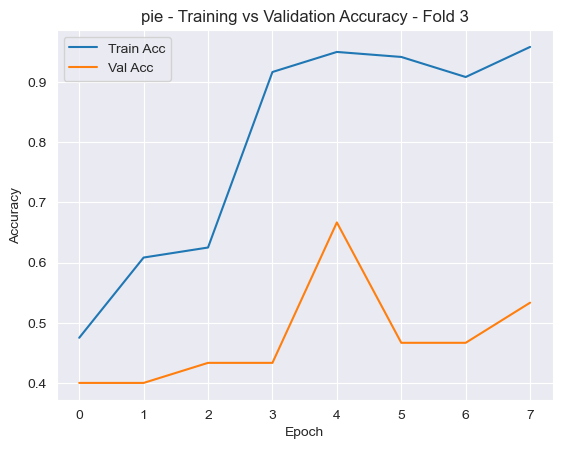

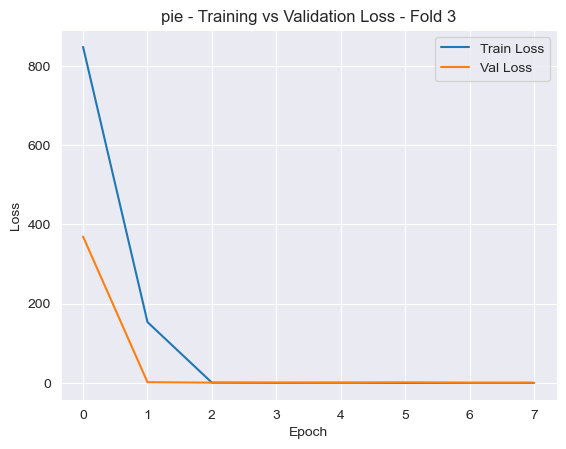

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


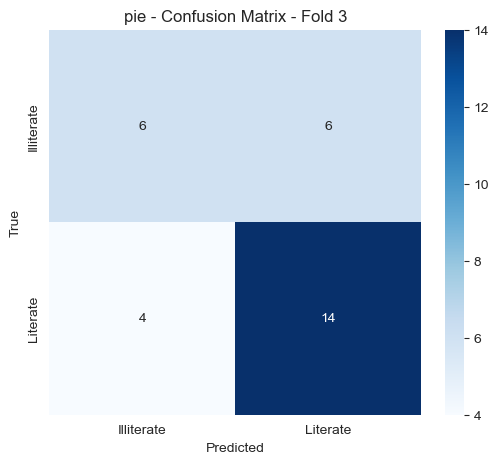

Fold 3 Final Train Acc: 0.9583, Final Val Acc: 0.5333
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.4590 - loss: 427.9979 - val_accuracy: 0.4000 - val_loss: 179.2942
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.5469 - loss: 68.9155 - val_accuracy: 0.7000 - val_loss: 0.6623
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.7215 - loss: 0.6283 - val_accuracy: 0.5667 - val_loss: 0.6633
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.6894 - loss: 0.5797 - val_accuracy: 0.6000 - val_loss: 0.7177
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9369 - loss: 0.2108 - val_accuracy: 0.5667 - val_loss: 0.9263


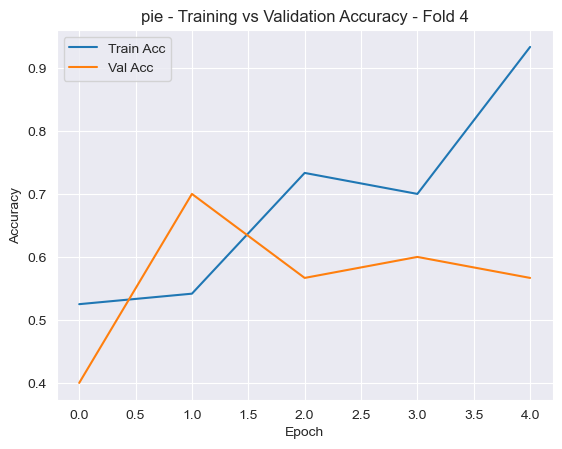

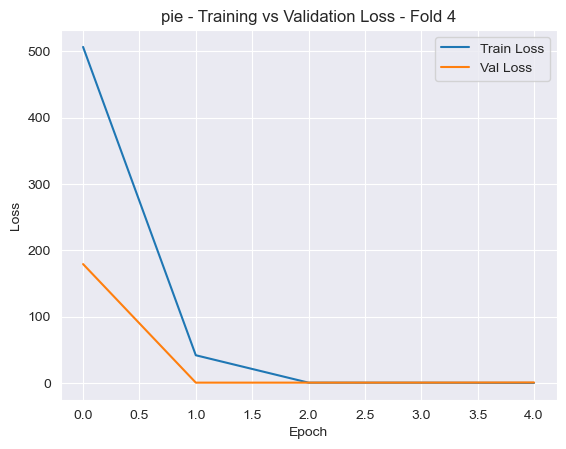

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


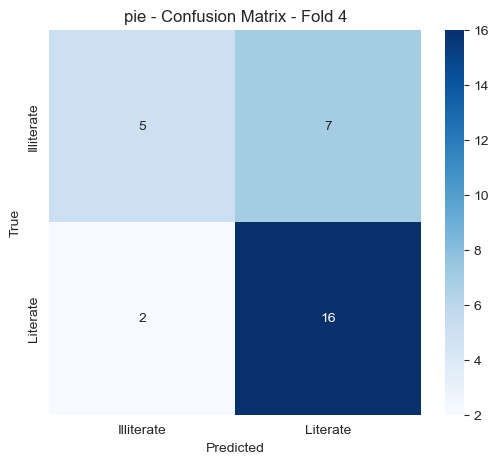

Fold 4 Final Train Acc: 0.9333, Final Val Acc: 0.5667
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.4590 - loss: 218.8636 - val_accuracy: 0.6000 - val_loss: 3.4559
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.5667 - loss: 2.9366 - val_accuracy: 0.5000 - val_loss: 0.7943
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.8006 - loss: 0.4781 - val_accuracy: 0.5667 - val_loss: 0.7258
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.8544 - loss: 0.4283 - val_accuracy: 0.6333 - val_loss: 0.7218
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9313 - loss: 0.2370 - val_accuracy: 0.6667 - val_loss: 1.0585
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9710 - loss: 0.1419 - val_accuracy: 0.6667 - val_loss: 1.3788
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/st

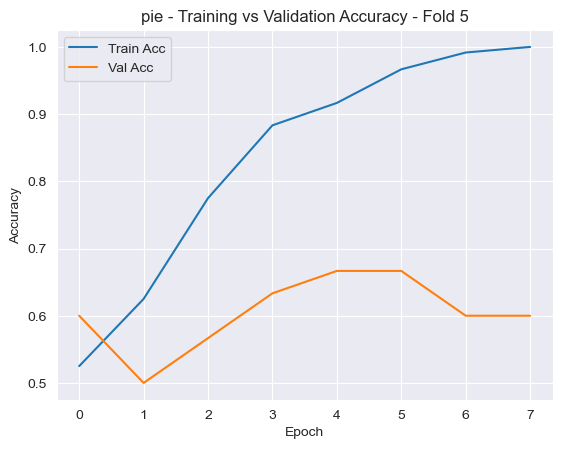

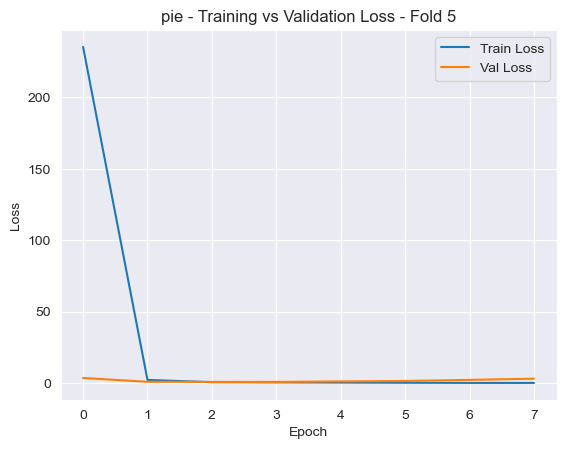

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


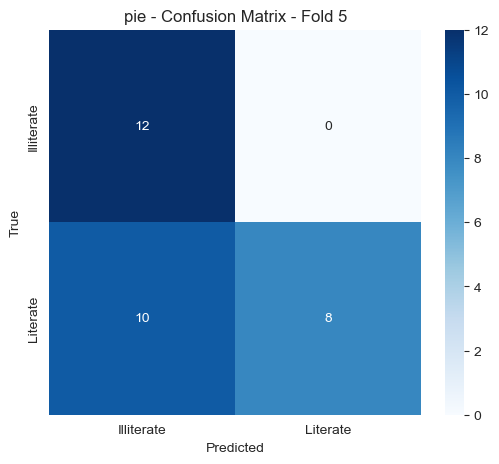

Fold 5 Final Train Acc: 1.0000, Final Val Acc: 0.6000


In [21]:
# Dictionary to hold results per graph type
all_results = {}

# Train and collect results
for dataset_name in ["bar", "line", "pie"]:
    print(f"\n=== Running 5-fold CV for: {dataset_name} ===")
    average_results = {
        "train_accuracies": [],
        "val_accuracies": []
    }

    for fold in range(5):
        train_and_evaluate(dataset_name, fold, average_results)

    # Store the mean results for this dataset
    all_results[dataset_name] = {
        "mean_train": np.mean(average_results["train_accuracies"]),
        "mean_val": np.mean(average_results["val_accuracies"])
    }

In [22]:
# After training all datasets, print summary
print("\n=== Summary of Average Accuracies by Graph Type ===")
for dataset_name, result in all_results.items():
    print(f"\nGraph Type: {dataset_name}")
    print(f"→ Average Train Accuracy: {result['mean_train']:.4f}")
    print(f"→ Average Validation Accuracy: {result['mean_val']:.4f}")


=== Summary of Average Accuracies by Graph Type ===

Graph Type: bar
→ Average Train Accuracy: 0.8564
→ Average Validation Accuracy: 0.5652

Graph Type: line
→ Average Train Accuracy: 0.8263
→ Average Validation Accuracy: 0.6456

Graph Type: pie
→ Average Train Accuracy: 0.9017
→ Average Validation Accuracy: 0.5333


In [ ]:
# Experiment with big kerel but and big model
# Try heatmaps
# Document everything